In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

In [3]:
image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\Temp\LIOR\Images\Train'
validation_data_dir = r'C:\Temp\LIOR\Images\Validation'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 1607 images belonging to 20 classes.
Found 557 images belonging to 20 classes.


In [4]:
x_batch, y_batch = next(train_generator)

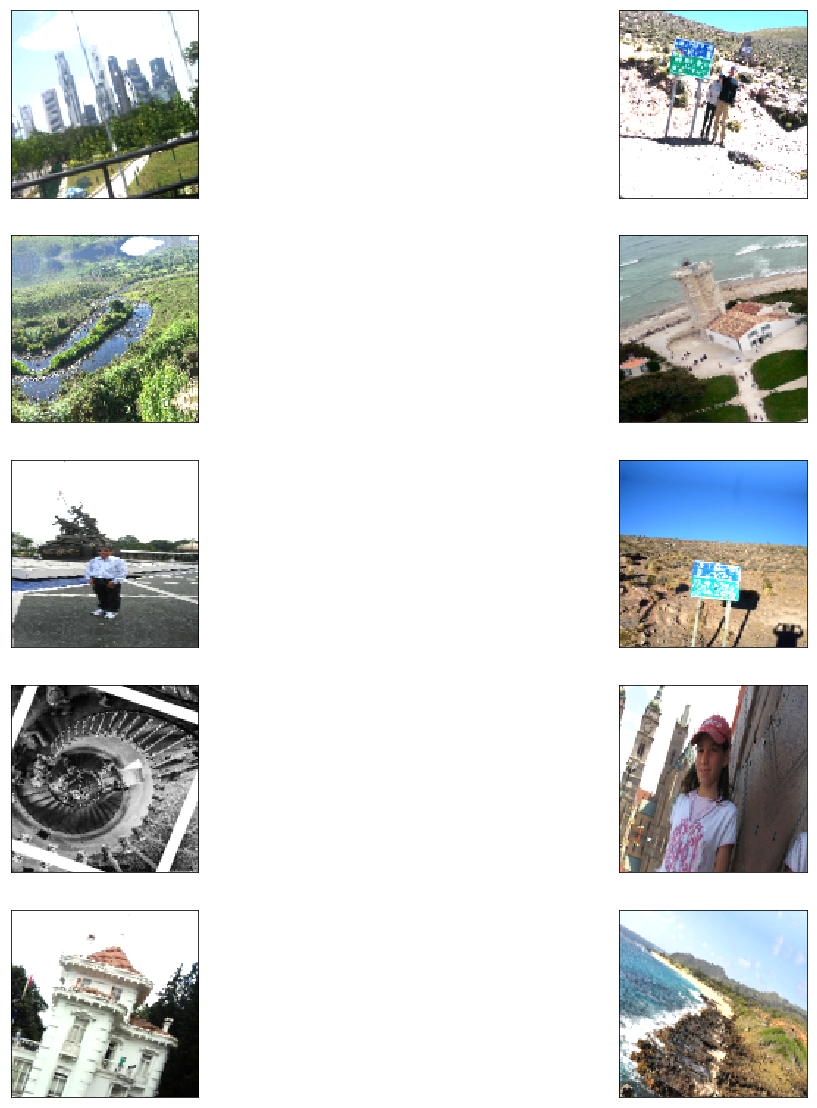

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

In [6]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [7]:
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

58892288/58889256 [==============================] - 5s 0us/step


In [8]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [9]:
for layer in base_model.layers[:17]:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2


In [10]:
for layer in base_model.layers[:17]:
    layer.trainable = False

In [13]:
classCount = 20

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
preds=Dense(classCount,activation='softmax')(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)

In [15]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [16]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

In [17]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

160


In [18]:
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        
history = LossAccHistory()

In [19]:
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=3
                   ,callbacks = [history])

Epoch 1/3
160/160 [==============================] - 201s 1s/step - loss: 13.5460 - acc: 0.1000 - val_loss: 15.4236 - val_acc: 0.0431
Epoch 2/3
160/160 [==============================] - 200s 1s/step - loss: 15.3079 - acc: 0.0503 - val_loss: 15.4236 - val_acc: 0.0431
Epoch 3/3
160/160 [==============================] - 202s 1s/step - loss: 15.2935 - acc: 0.0512 - val_loss: 15.4236 - val_acc: 0.0431


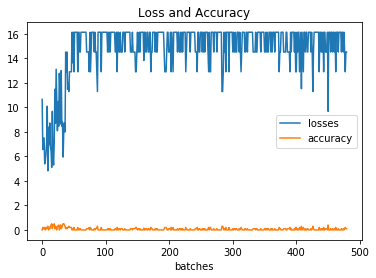

In [20]:
import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])

In [21]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

In [25]:
import time

networkfileName = "D:\Lior\\vgg16_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [26]:
history = LossAccHistory()
model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=3
                   ,callbacks = [history, checkpoint, early])

Epoch 1/3
159/160 [============================>.] - ETA: 0s - loss: 15.3086 - acc: 0.0502
Epoch 00001: val_acc improved from -inf to 0.04309, saving model to D:\Lior\vgg16_1547044857.h5
160/160 [==============================] - 203s 1s/step - loss: 15.3137 - acc: 0.0499 - val_loss: 15.4236 - val_acc: 0.0431
Epoch 2/3
159/160 [============================>.] - ETA: 0s - loss: 15.2926 - acc: 0.0512
Epoch 00002: val_acc did not improve from 0.04309
160/160 [==============================] - 202s 1s/step - loss: 15.2978 - acc: 0.0509 - val_loss: 15.4236 - val_acc: 0.0431
Epoch 3/3
159/160 [============================>.] - ETA: 0s - loss: 15.3578 - acc: 0.0472
Epoch 00003: val_acc did not improve from 0.04309
160/160 [==============================] - 201s 1s/step - loss: 15.3525 - acc: 0.0475 - val_loss: 15.4236 - val_acc: 0.0431
Epoch 00003: early stopping


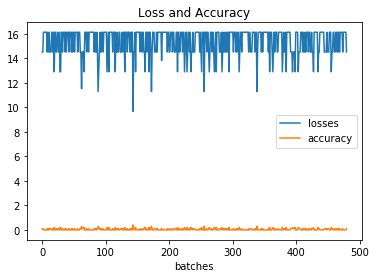

In [27]:

import matplotlib.pyplot as plt
x = range(0, len(history.losses))
plt.plot(x, history.losses)
plt.plot(x, history.accuracy)
plt.xlabel('batches')
plt.title('Loss and Accuracy')
plt.legend(['losses', 'accuracy'])